Copyright (c) 2024 Massachusetts Institute of Technology

SPDX-License-Identifier: MIT

# Example 1: Propagate a Satellite

In this example we will use `astroforge` to propagate a geostationary satellite using two separate force models.

## Defining the Satellite

In `astroforge`, a satellite is simply defined by its position and velocity. The coordinate system used is *TETED* (True Equinox and True Equator of Date, see [here](https://docs.astropy.org/en/stable/api/astropy.coordinates.TETE.html) and [here](https://en.wikipedia.org/wiki/Equatorial_coordinate_system#Primary_direction)), and the units are km and km/s.

Our geostationary satellite will lie on the x-axis, with its velocity pointing in the y direction.

In [ ]:
import numpy as np

GM = 398600.4418   # Geocentric gravitational constant (km**3 / s**2)
r0 = 42164.0   # Geostationary distance from Earth's center (km)
v0 = np.sqrt(GM / r0)   # Speed (km/s)

x0 = np.array([r0, 0, 0, 0, v0, 0])

Note that the position and velocity are defined together in a six-element array.

## Defining the Propagation Parameters

We must next decide how we want to propagate the satellite. We'll define a series of times (in seconds, starting at 0) at which we'll record the satellite's state.

We will also define how precisely to solve the differential equations within our propagators by setting an absolute tolerance (`atol`) and a relative tolerance (`rtol`). For more information, see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

In [2]:
# We'll take 1000 evenly spaced observations for one day (86400 seconds)
t_eval = np.linspace(0.0, 86400.0, 1000)

atol = 1e-9
rtol = 1e-9

## Selecting a Force Model and Propagating

When propagating an orbit, you can typically choose between fast, low-precision force models or high-precision models that take longer to compute. Force models also vary in how they handle atmospheric drag and solar radiation pressure (SRP). The choice you make depends on your specific modeling needs.

In `astroforge`, we currently offer three different force models:
1. `kepler`, a simple two-body model that ignores the effects of air resistance and SRP.
2. `F_mp`, a medium-fidelity force model including J2 perturbations and perturbations from the sun and moon.
3. `F_mp_srp`, a medium-fidelity model using an 8x8 spherical harmonic Earth gravity model, sun and moon perturbations, and a SRP model.

For inputs, both `kepler` and `F_mp` only require the time (expressed as a Modified Julian Date) and the satellite's six-element state vector. `F_mp_srp` requires 3 additional time-constant coefficients defining the SRP model (please see the API documentaiton for `force_models._models.F_mp_srp` for more details.)

In this example, we will compare the performances of `kepler` and `F_mp`.

In [3]:
import time
import astroforge as af

t0 = time.time()
x_kepler = af.propagators.propagator(af.force_models.kepler, x0, t_eval, atol=atol, rtol=rtol)
t_kepler = time.time() - t0

t0 = time.time()
x_mp = af.propagators.propagator(af.force_models.F_mp, x0, t_eval, atol=atol, rtol=rtol)
t_mp = time.time() - t0

print(f"Two-body propagation took {t_kepler:.5f} seconds.")
print(f"Medium Precision propagation took {t_mp:.5f} seconds.")

Two-body propagation took 14.50363 seconds.
Medium Precision propagation took 19.24923 seconds.


The outputs of our propagations, `x_kepler` and `x_mp` are Nx6 numpy arrays, where N is the number of timesteps (in our case, 1000). Each row of this array is the 6-element state vector at the corresponding timestep.

In [4]:
x_kepler.shape

(1000, 6)

Now let's plot the two orbits to see if we can spot any differences.

Text(0, 0.5, 'Z-axis (km)')

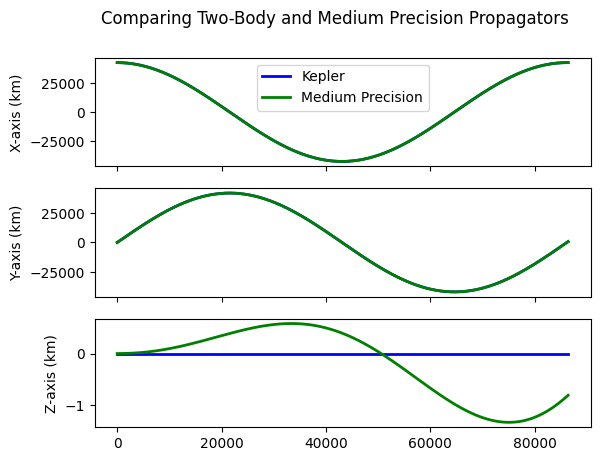

In [5]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.suptitle("Comparing Two-Body and Medium Precision Propagators")

ax1.plot(t_eval, x_kepler[:,0], "b", lw=2, label="Kepler")
ax1.plot(t_eval, x_mp[:,0], "g", lw=2, label="Medium Precision")
ax1.set_ylabel("X-axis (km)")
ax1.legend()

ax2.plot(t_eval, x_kepler[:,1], "b", lw=2, label="Kepler")
ax2.plot(t_eval, x_mp[:,1], "g", lw=2, label="Medium Precision")
ax2.set_ylabel("Y-axis (km)")

ax3.plot(t_eval, x_kepler[:,2], "b", lw=2, label="Kepler")
ax3.plot(t_eval, x_mp[:,2], "g", lw=2, label="Medium Precision")
ax3.set_ylabel("Z-axis (km)")

Well, look at that! The differences in the X and Y axes are too small to see at this scale, but it's obvious that the Kepler propagator misses some very slight disturbances in the Z-axis due to the perturbations included in the Medium Precision model.